In [ ]:
# Try LSTM and its variants

In [4]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import time
import gc
import sys

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
from sklearn.metrics import r2_score,mean_squared_error
from sklearn import metrics

2021-09-03 09:01:33.410981: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [5]:
data=pd.read_csv('data_modified.csv')
data['DateTime']=pd.to_datetime(data['DateTime'])
data=data.set_index('DateTime')

In [6]:
dff=data.copy()
print(dff.isnull().sum().any())
#dff=df.copy()
split=int(0.75*len(dff))
train_data=dff[:split]
test_data=dff[split:]
print(train_data.shape,test_data.shape)
print(train_data.index.min(),train_data.index.max())
print(test_data.index.min(),test_data.index.max()) ##??
print(train_data.index.max()-train_data.index.min())
print(test_data.index.max()-test_data.index.min())

False
(1512, 45) (505, 45)
2020-10-15 18:35:00 2020-10-16 19:46:00
2020-10-16 19:47:00 2020-10-17 04:11:00
1 days 01:11:00
0 days 08:24:00


In [7]:
dff=dff[['BRNDMD', 'WFPILM', 'F_FARFLI', 'F_FARFLO', 'F_FARFL',
       'F_W2', 'F_WA36', 'F_WB3Q', 'F_WF36DMD', 'P2SEL', 'PS3SEL', 'T2SEL',
       'T3SEL', 'TFLCYCS', 'TFLPDFS', 'TFLIDFS', 'TFLODFS', 'WFINRM', 'WFOTRM',
       'WFQPERRCOR', 'A90RH', 'F_WAFL', 'NGGSEL', 'PX36SEL', 'PX36AVAL',
       'PX36BVAL', 'NPTSEL', 'NPTREF', 'DWB36PCT', 'REGULATOR', 'T48SEL',
       'CDPSEL', 'T8SEL', 'P48SEL', 'LHVSEL', 'SGSEL','O2_HMI', 'VLVFBKG_06','SSFILTER', 'F_WB3','NOX_HMI','CO_HMI' ]]

In [8]:
# validate data for 15 minutes with its predictions 15 minutes
print(dff.shape)
validate=dff.tail(15)
print(validate.shape)
dff.drop(dff.tail(15).index,inplace=True)

(2017, 42)
(15, 42)


In [9]:
validate['CO_HMI'].shape

(15,)

In [10]:
print(dff.shape)

(2002, 42)


In [11]:
X_data=dff[['BRNDMD', 'WFPILM', 'F_FARFLI', 'F_FARFLO', 'F_FARFL', 'F_W2', 'F_WA36',
       'F_WB3Q', 'F_WF36DMD', 'P2SEL', 'PS3SEL', 'T2SEL', 'T3SEL', 'TFLCYCS',
       'TFLPDFS', 'TFLIDFS', 'TFLODFS', 'WFINRM', 'WFOTRM', 'WFQPERRCOR',
       'A90RH', 'F_WAFL', 'NGGSEL', 'PX36SEL', 'PX36AVAL', 'PX36BVAL',
       'NPTSEL', 'NPTREF', 'DWB36PCT', 'REGULATOR', 'T48SEL', 'CDPSEL',
       'T8SEL', 'P48SEL', 'LHVSEL', 'SGSEL', 'O2_HMI',
       'VLVFBKG_06', 'SSFILTER', 'F_WB3','NOX_HMI','CO_HMI']]
Y_data=dff[['CO_HMI']]

In [ ]:
# X_data=X_data.values
# Y_data=Y_data.values

In [12]:
X_scaler=MinMaxScaler()
Y_scaler=MinMaxScaler()
x_data=X_scaler.fit_transform(X_data)
y_data=Y_scaler.fit_transform(Y_data)

In [13]:

def data_lstm(dataset,target,start,end,past_history,n_future):
    X=[]
    y=[]
    start=start+past_history
    if end is None:
        end=len(dataset)-n_future
    for i in range(start,end):
        indices=range(i-past_history,i)
        X.append(dataset[indices])
        indices_y=range(i+1,i+1+n_future)
        y.append(target[indices_y])
   
    return np.array(X), np.array(y)

In [14]:
#60, 15 
split=int(len(dff)*(80/100))
past_history=60
n_future=15
TRAIN_SPLIT=split
x_train,y_train=data_lstm(x_data,y_data,0,TRAIN_SPLIT,past_history,n_future)
x_val,y_val=data_lstm(x_data,y_data,TRAIN_SPLIT,None,past_history,n_future)


In [15]:
print(x_train.shape,y_train.shape,x_val.shape,y_val.shape)

(1541, 60, 42) (1541, 15, 1) (326, 60, 42) (326, 15, 1)


In [16]:
batch_size=32
buffer_size=50
train_data=tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_data=train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data=tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_data=val_data.batch(batch_size).repeat()

2021-09-03 09:02:09.540854: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-09-03 09:02:09.666122: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:8a:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-09-03 09:02:09.666162: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-09-03 09:02:09.671398: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-09-03 09:02:09.671450: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-09-03 09:02:09.674435: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.

In [ ]:
#  kernel_regularizer=keras.regularizers.l2(kr),
#                         recurrent_regularizer=keras.regularizers.l2(rr),
#                         bias_regularizer=keras.regularizers.l2(br)

In [66]:
lstm_bidirectional_model = tf.keras.models.Sequential([
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True), 
                                input_shape=x_train.shape[-2:]),
     tf.keras.layers.Dense(8, activation='tanh'),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
     tf.keras.layers.Dense(8, activation='tanh'),
     tf.keras.layers.Dense(4, activation='tanh'),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(units=n_future),
 ])
lstm_bidirectional_model.compile(optimizer='adam', loss='mse')
lstm_bidirectional_model.summary() 


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_20 (Bidirectio (None, 60, 32)            7552      
_________________________________________________________________
dense_39 (Dense)             (None, 60, 8)             264       
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 100)               23600     
_________________________________________________________________
dense_40 (Dense)             (None, 8)                 808       
_________________________________________________________________
dense_41 (Dense)             (None, 4)                 36        
_________________________________________________________________
dropout_10 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_42 (Dense)             (None, 15)               

In [67]:
# from tf set tensor slicing
#early_stopings=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1,mode='min')
history=lstm_bidirectional_model.fit(train_data,epochs=150,steps_per_epoch=45,validation_data=val_data,
                    validation_steps=20,verbose=1)


Epoch 1/150
45/45 [==============================] - 9s 65ms/step - loss: 0.1137 - val_loss: 0.1826
Epoch 2/150
45/45 [==============================] - 1s 19ms/step - loss: 0.0889 - val_loss: 0.1373
Epoch 3/150
45/45 [==============================] - 1s 20ms/step - loss: 0.0665 - val_loss: 0.0673
Epoch 4/150
45/45 [==============================] - 1s 19ms/step - loss: 0.0493 - val_loss: 0.0352
Epoch 5/150
45/45 [==============================] - 1s 20ms/step - loss: 0.0426 - val_loss: 0.0239
Epoch 6/150
45/45 [==============================] - 1s 19ms/step - loss: 0.0407 - val_loss: 0.0164
Epoch 7/150
45/45 [==============================] - 1s 19ms/step - loss: 0.0369 - val_loss: 0.0122
Epoch 8/150
45/45 [==============================] - 1s 19ms/step - loss: 0.0274 - val_loss: 0.0093
Epoch 9/150
45/45 [==============================] - 1s 19ms/step - loss: 0.0239 - val_loss: 0.0090
Epoch 10/150
45/45 [==============================] - 1s 20ms/step - loss: 0.0229 - val_loss: 0.0079

45/45 [==============================] - 1s 19ms/step - loss: 0.0109 - val_loss: 0.0567
Epoch 83/150
45/45 [==============================] - 1s 19ms/step - loss: 0.0099 - val_loss: 0.0262
Epoch 84/150
45/45 [==============================] - 1s 20ms/step - loss: 0.0113 - val_loss: 0.0101
Epoch 85/150
45/45 [==============================] - 1s 19ms/step - loss: 0.0108 - val_loss: 0.0049
Epoch 86/150
45/45 [==============================] - 1s 19ms/step - loss: 0.0096 - val_loss: 0.0196
Epoch 87/150
45/45 [==============================] - 1s 19ms/step - loss: 0.0090 - val_loss: 0.0078
Epoch 88/150
45/45 [==============================] - 1s 19ms/step - loss: 0.0124 - val_loss: 0.0283
Epoch 89/150
45/45 [==============================] - 1s 20ms/step - loss: 0.0103 - val_loss: 0.0117
Epoch 90/150
45/45 [==============================] - 1s 20ms/step - loss: 0.0101 - val_loss: 0.0288
Epoch 91/150
45/45 [==============================] - 1s 20ms/step - loss: 0.0090 - val_loss: 0.0363
Epo

In [ ]:
#history=model.fit(x_train,y_train,epochs=150,validation_data=(x_val,y_val),batch_size=32,verbose=1,shuffle=False)


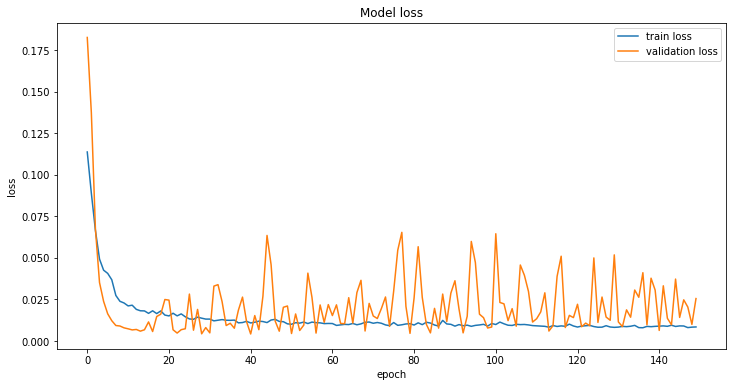

In [68]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss','validation loss'])
plt.show()



In [ ]:
# model_path='simple_LSTM_Multivariate.h5'
# early_stopings=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=50,verbose=1,mode='min')
# checkpoint=tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss',save_best_only=True,mode='min',verbose=0)
# callbacks=[early_stopings,checkpoint]
# history_1=model.fit(x_train,y_train,epochs=150,validation_data=(x_val,y_val),batch_size=32,verbose=1,shuffle=False,callbacks=callbacks)


In [69]:
#print(X_data.tail(15).shape)
data_val=X_scaler.fit_transform((X_data).tail(60))
val_rescaled=data_val.reshape(1,data_val.shape[0],data_val.shape[1])
val_rescaled.shape

(1, 60, 42)

In [70]:
pred=lstm_bidirectional_model.predict(val_rescaled)
pred_inverse=Y_scaler.inverse_transform(pred)
pred_inverse

array([[4.6183834, 4.6147704, 4.6133027, 4.6063976, 4.605173 , 4.599367 ,
        4.585667 , 4.5781665, 4.5714064, 4.5612464, 4.552951 , 4.548793 ,
        4.5439224, 4.5351167, 4.5299363]], dtype=float32)

In [58]:
#Evaluation Metrics

In [64]:
def eval_metrics(y_true,y_pred):
    def mean_absolute_percentage_error(y_true,y_pred):
        y_true,y_pred=np.array(y_true),np.array(y_pred)
        return np.mean(np.abs((y_true-y_pred) / y_true)) * 100
    print('Evaluation Metrics-----')
    print('-----------------------')
    print(f'MSE is: {metrics.mean_squared_error(y_true,y_pred)}')
    print(f'MAE is: {metrics.mean_absolute_error(y_true,y_pred)}')
    print(f'RMSE is: {np.sqrt(metrics.mean_squared_error(y_true,y_pred))}')
    print(f'MAPE is: {mean_absolute_percentage_error(y_true,y_pred)}')
    print(f'R2 is {metrics.r2_score(y_true,y_pred)}', end='\n\n')
    
        

In [71]:
eval_metrics(validate['CO_HMI'],pred_inverse[0])

Evaluation Metrics-----
-----------------------
MSE is: 0.09165054814681908
MAE is: 0.26716912590151354
RMSE is: 0.30273841538004237
MAPE is: 5.437026076791488
R2 is -3.537966826953686



In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(validate['CO_HMI'].values, label='CO_HMI')
plt.plot(pred_inverse[0], label='CO_HMI_predicted')
plt.legend()
plt.show()